In [11]:
from IPython.display import Image, display


Displaying image: apple.jpg


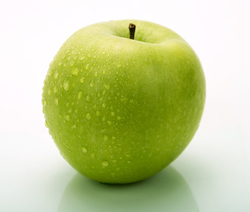


Displaying image: clock.jpg


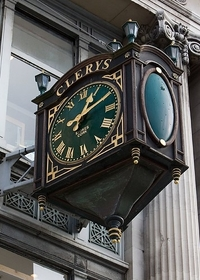


Displaying image: oranges.jpg


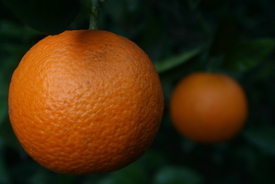


Displaying image: car.jpg


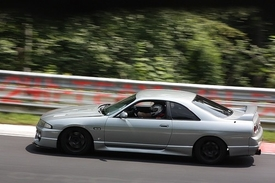

In [12]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

In [13]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [14]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    
    
    img_filepath = f'images/{filename}'
    
    img = cv2.imread(img_filepath)

    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    

    print(f"========================\nImage processed: {filename}\n")
    

    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    

    output_image = draw_bbox(img, bbox, label, conf)
    

    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    

    display(Image(f'images_with_boxes/{filename}'))

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717183351516724



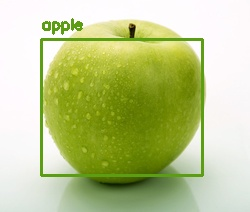

Image processed: clock.jpg

Detected object: clock with confidence level of 0.968317985534668



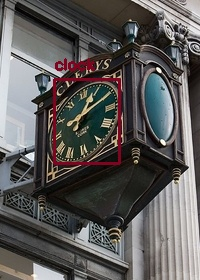

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185599565505981

Detected object: orange with confidence level of 0.5561732053756714



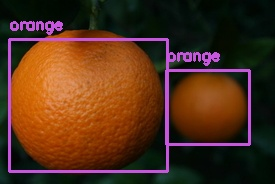

Image processed: car.jpg

Detected object: car with confidence level of 0.6325422525405884



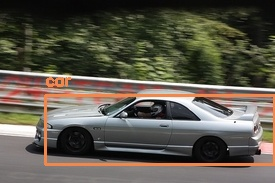

In [15]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818485617637634

Detected object: orange with confidence level of 0.5346476435661316

Detected object: orange with confidence level of 0.5150948166847229

Detected object: apple with confidence level of 0.3476020395755768

Detected object: orange with confidence level of 0.32876279950141907

Detected object: apple with confidence level of 0.3124457597732544

Detected object: orange with confidence level of 0.27985894680023193

Detected object: orange with confidence level of 0.27499887347221375

Detected object: apple with confidence level of 0.2744504511356354

Detected object: orange with confidence level of 0.21419422328472137



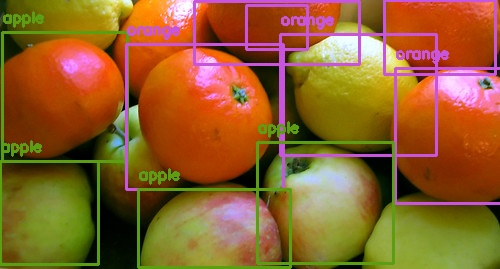

In [16]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

In [17]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [18]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [19]:
app = FastAPI(title='Deploying a ML Model with FastAPI')

class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"



@app.post("/predict") 
async def prediction(model: Model, file: UploadFile = File(...)):

    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [20]:
nest_asyncio.apply()

host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"
   
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [17340]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:60802 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60802 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:60816 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:60816 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:60901 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:61042 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
